In [2]:
import numpy as np
import math
import torch
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
classes = 100
train_total = 50000

#modified from: 
#https://github.com/kekmodel/FixMatch-pytorch/blob/master/dataset/cifar.py 
def x_u_split(labels, labeled_per_class):
    np.random.seed(0) #make sure split are the same
    labels = np.array(labels)
    labeled_idx = []
    for i in range(classes):
        idx = np.where(labels == i)[0]
        idx = np.random.choice(idx, labeled_per_class, False)
        labeled_idx.extend(idx)
    labeled_idx = np.array(labeled_idx)
    np.random.shuffle(labeled_idx)
    np.random.seed() #optionally restore rng
    return labeled_idx, np.setdiff1d(range(train_total), labeled_idx)

class CIFAR100SSL(datasets.CIFAR100):
    def __init__(self, root, indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [3]:
mean,std = (0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)

transform_labeled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

ResNet

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [5]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [6]:
def train_model(model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler = None):
  train_loss = []
  for epoch in range(num_epochs):
    time1 = time.time()
    model.train()
    total_loss = 0
    for data, target in l_train_dataloader:
      optimizer.zero_grad()
      if gpu_boole:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      total_loss += loss.item()
      optimizer.step()
    if scheduler is not None:
      scheduler.step()
    train_loss.append(total_loss/len(l_train_dataloader))

    model.eval()
    correct_sum = 0
    with torch.no_grad():
      for data, target in test_dataloader:
        if gpu_boole:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct_sum += (predicted.float() == target.float()).sum().item()
    correct_sum2 = 0
    with torch.no_grad():
      for data, target in l_train_dataloader:
        if gpu_boole:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct_sum2 += (predicted.float() == target.float()).sum().item()
    time2 = time.time()
    print('epoch:', epoch+1, ' train loss:', total_loss/len(l_train_dataloader), \
          'train accuracy:', correct_sum2/len(train_labeled_dataset),\
          'val accuracy:', correct_sum/len(test_dataset))
    print('ETA of completion:',(time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')

  plt.plot(train_loss, label = 'training loss')
  plt.xlabel('Epoch Number')
  plt.ylabel('Average Traning Loss At Each Epoch')
  plt.legend()
  plt.title('Training Loss vs Epochs')
  plt.show()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


5 per class, 500 in total, 1:99

In [8]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 5

base_dataset = datasets.CIFAR100(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR100SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR100(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./tmp/cifar-100-python.tar.gz to ./tmp


In [11]:
from torch.nn.utils import weight_norm

ndf = 64
class Discriminator(nn.Module):
        def __init__(self,num_classes):
            super(Discriminator, self).__init__()
            self.net = nn.Sequential(
                    nn.Dropout(.2),
                    weight_norm(nn.Conv2d(3,ndf * 3,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 3,ndf * 3,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 3,ndf * 3,3,stride=2,padding=1)),
                    nn.LeakyReLU(),

                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(ndf * 3,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=2,padding=1)),
                    nn.LeakyReLU(),
                    
                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,3,stride=1,padding=0)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,1,stride=1,padding=0)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(ndf * 6,ndf * 6,1,stride=1,padding=0)),
                    nn.LeakyReLU(),

                    # nn.AvgPool2d(6,stride=1),
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten()
                )

            self.fc = weight_norm(nn.Linear(ndf * 6,num_classes))
            
        def forward(self,x):
            inter_layer = self.net(x)
            logits = self.fc(inter_layer)
            return  logits
lr = 0.0001
num_epochs = 200

model = Discriminator(100)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=lr)
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    None)

RuntimeError: ignored

In [12]:
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    100,
    criterion,
    optimizer,
    None)

RuntimeError: ignored

epoch: 1  train loss: 0.6548098549246788 train accuracy: 0.89 val accuracy: 0.0588
ETA of completion: 4.3294522047042845 minutes
epoch: 2  train loss: 0.6746466755867004 train accuracy: 0.88 val accuracy: 0.0572
ETA of completion: 4.976130247116089 minutes
epoch: 3  train loss: 0.5908681452274323 train accuracy: 0.878 val accuracy: 0.055
ETA of completion: 5.116686725616455 minutes
epoch: 4  train loss: 0.6132162883877754 train accuracy: 0.89 val accuracy: 0.0569
ETA of completion: 4.3424335479736325 minutes
epoch: 5  train loss: 0.6279124319553375 train accuracy: 0.894 val accuracy: 0.0566
ETA of completion: 4.138268729050954 minutes
epoch: 6  train loss: 0.5122985243797302 train accuracy: 0.922 val accuracy: 0.0533
ETA of completion: 4.09287961324056 minutes
epoch: 7  train loss: 0.46526364982128143 train accuracy: 0.92 val accuracy: 0.0533
ETA of completion: 4.172413611412049 minutes
epoch: 8  train loss: 0.5320953577756882 train accuracy: 0.916 val accuracy: 0.0584
ETA of completio

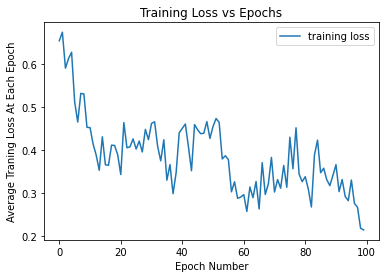

In [ ]:
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    0.00001,
    100,
    criterion,
    optimizer,
    None)

25 per class, 2500 in total, 1:19

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 25

base_dataset = datasets.CIFAR100(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR100SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR100(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Files already downloaded and verified


epoch: 1  train loss: 4.507874703407287 train accuracy: 0.0764 val accuracy: 0.0568
ETA of completion: 4.359107557932536 minutes
epoch: 2  train loss: 3.525484597682953 train accuracy: 0.282 val accuracy: 0.1603
ETA of completion: 4.441616439819336 minutes
epoch: 3  train loss: 2.799898886680603 train accuracy: 0.3792 val accuracy: 0.2063
ETA of completion: 4.088364100456237 minutes
epoch: 4  train loss: 2.267465078830719 train accuracy: 0.5108 val accuracy: 0.2372
ETA of completion: 4.163423569997152 minutes
epoch: 5  train loss: 1.7400284469127656 train accuracy: 0.606 val accuracy: 0.2422
ETA of completion: 4.182978808879852 minutes
epoch: 6  train loss: 1.511525958776474 train accuracy: 0.6452 val accuracy: 0.2508
ETA of completion: 3.8177395184834797 minutes
epoch: 7  train loss: 1.2493538230657577 train accuracy: 0.6956 val accuracy: 0.2538
ETA of completion: 3.7535202741622924 minutes
epoch: 8  train loss: 0.9918851763010025 train accuracy: 0.7992 val accuracy: 0.2759
ETA of com

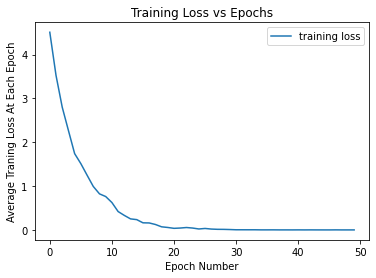

In [ ]:
lr = 0.001
num_epochs = 50

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler)
torch.save(model.state_dict(), '/content/drive/MyDrive/MLDL/cifar100/model/25_ResNet.pth')

50 per class, 5000 in total, 1:9

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 50

base_dataset = datasets.CIFAR100(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR100SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR100(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Files already downloaded and verified


epoch: 1  train loss: 4.239776486158371 train accuracy: 0.1972 val accuracy: 0.1514
ETA of completion: 6.376514907677969 minutes
epoch: 2  train loss: 3.220260727405548 train accuracy: 0.323 val accuracy: 0.2269
ETA of completion: 6.162803649902344 minutes
epoch: 3  train loss: 2.8739762008190155 train accuracy: 0.3388 val accuracy: 0.2338
ETA of completion: 5.8488698641459145 minutes
epoch: 4  train loss: 2.431179091334343 train accuracy: 0.497 val accuracy: 0.3073
ETA of completion: 5.831791226069132 minutes
epoch: 5  train loss: 1.9537159740924834 train accuracy: 0.3742 val accuracy: 0.2259
ETA of completion: 5.66126149892807 minutes
epoch: 6  train loss: 2.204891490936279 train accuracy: 0.5064 val accuracy: 0.298
ETA of completion: 5.554154682159424 minutes
epoch: 7  train loss: 1.7864590793848039 train accuracy: 0.6386 val accuracy: 0.3282
ETA of completion: 5.530282926559448 minutes
epoch: 8  train loss: 1.3890062987804412 train accuracy: 0.7686 val accuracy: 0.3557
ETA of compl

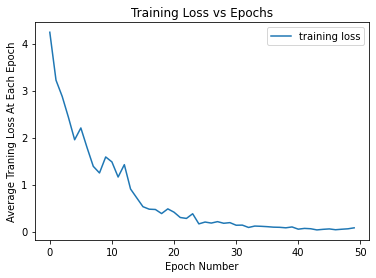

In [ ]:
lr = 0.001
num_epochs = 50

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler)
torch.save(model.state_dict(), '/content/drive/MyDrive/MLDL/cifar100/model/50_ResNet.pth')

100 per class, 10000 in total, 1:4

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 100

base_dataset = datasets.CIFAR100(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR100SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR100(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./tmp/cifar-100-python.tar.gz to ./tmp


epoch: 1  train loss: 3.784946529171135 train accuracy: 0.2509 val accuracy: 0.2205
ETA of completion: 10.519986494382222 minutes
epoch: 2  train loss: 3.0072914437402654 train accuracy: 0.2986 val accuracy: 0.2452
ETA of completion: 10.325381851196289 minutes
epoch: 3  train loss: 2.5520917856240573 train accuracy: 0.4656 val accuracy: 0.3494
ETA of completion: 9.331301192442575 minutes
epoch: 4  train loss: 2.352513520023491 train accuracy: 0.3406 val accuracy: 0.2704
ETA of completion: 9.055188369750976 minutes
epoch: 5  train loss: 2.4136036664624756 train accuracy: 0.4431 val accuracy: 0.3193
ETA of completion: 9.374993205070496 minutes
epoch: 6  train loss: 1.8917563187925122 train accuracy: 0.5987 val accuracy: 0.3794
ETA of completion: 8.648284260431925 minutes
epoch: 7  train loss: 1.6503616888311845 train accuracy: 0.69 val accuracy: 0.4157
ETA of completion: 8.465306504567463 minutes
epoch: 8  train loss: 1.3269605138633824 train accuracy: 0.6713 val accuracy: 0.3883
ETA of 

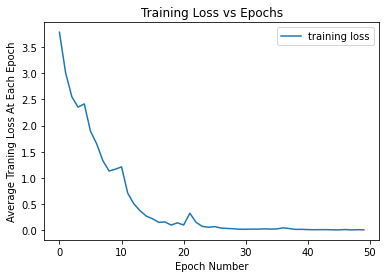

FileNotFoundError: ignored

In [ ]:
lr = 0.001
num_epochs = 50

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler)
torch.save(model.state_dict(), '/content/drive/MyDrive/MLDL/cifar100/model/100_ResNet.pth')